## BM25 application and evaluation

In this notebook we apply and evaluate BM25

Different cells can be run for different ways of preprocessing, always keep the order in which you run cells in mind.

In [1]:
import pandas as pd
import string
import bm25s

In [2]:
# first we load the entire corpus on which the BM25 algorithm is fit
corpus = pd.read_csv('data/corpus_without_outliers.csv.zip')

In [ ]:
# we load the sample on which we evaluate
stratified_sample = pd.read_csv('data/stratified_sample_with_queries.csv')

In [3]:
# load this instead if you're here to evaluate the translated queries, 

stratified_sample = pd.read_csv('data/stratified_sample_with_translated_queries.csv')

# in the rest of the code, replace 'query_en' and 'query_nl' by 'translation_en' and 'translation_nl'

In [ ]:
# run this cell if you want to do the experiment on a subset of the data, based on query length
# use longest_half or shortest_half in the rest of the code instead of stratified_sample

# calculate the mean query length for each row
stratified_sample['mean_query_length'] = stratified_sample[['English Query Length', 'Dutch Query Length']].mean(axis=1)

median_mean_length = stratified_sample['mean_query_length'].median()

# and take the half with the longest queries
longest_half = stratified_sample[stratified_sample['mean_query_length'] >= median_mean_length].reset_index().copy()

# half with the shortest queries
shortest_half = stratified_sample[stratified_sample['mean_query_length'] < median_mean_length].reset_index().copy() 

print(len(longest_half))
print(len(shortest_half))

751
749


In [5]:
# basic preprocessing: removing punctuation, lowercasing all text and splitting into words

def preprocess_columns (column):
    # lowercase and remove punctuation using vectorized string methods
    clean_series = column.str.lower().str.translate(str.maketrans('', '', string.punctuation)) 
    corpus = clean_series.str.split().tolist()
    return corpus

In [15]:
# NLTK's word_tokenize(), without any lowercasing or punctuation removal. 

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def preprocess_columns(column):
    return column.apply(lambda text: word_tokenize(text))


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/corfrederickx/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# removing punctuation, lowercasing all text and using NLTK's word_tokenize(). This is the optimal tokenization strategy we decide on.

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def preprocess_columns(column):
    # Lowercase and remove punctuation using vectorized string methods
    clean_series = column.str.lower().str.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize using nltk's word_tokenize
    return clean_series.apply(word_tokenize)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/corfrederickx/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [29]:
# lowercasing all text and using NLTK's word_tokenize(), but removing punctuation afterwards. 

import string
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

def preprocess_columns(column):
    # lowercase the text
    clean_series = column.str.lower()
    
    # tokenize
    tokenized_series = clean_series.apply(word_tokenize)
    
    # remove punctuation tokens
    tokenized_series = tokenized_series.apply(
        lambda tokens: [token for token in tokens if token not in string.punctuation]
    )
    
    return tokenized_series


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/corfrederickx/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [38]:
# removing punctuation, lowercasing all text and using tiktoken.
# necessary to decode resulting tokens back to strings to make them compatible with BM25s

import tiktoken

def preprocess_columns(column):
    clean_series = column.str.lower().str.translate(str.maketrans('', '', string.punctuation))
    encoding = tiktoken.encoding_for_model("gpt-4")
    corpus = clean_series.apply(lambda x: [encoding.decode_single_token_bytes(token).decode("utf-8", errors="ignore") for token in encoding.encode(x)]).tolist()
    return corpus


In [6]:
# BM25S with default hyperparameters

def apply_bm25(text_column, query_column, celex_ids):

    celex_ids = list(celex_ids)

    corpus_tokens = preprocess_columns(text_column)
    query_tokens = preprocess_columns(query_column)

    retriever = bm25s.BM25()
    retriever.index(corpus_tokens)

    results = retriever.retrieve(query_tokens, corpus=celex_ids, k=50, return_as="documents") # returns a numpy array

    stratified_sample['retrieved_celex_ids'] = results.tolist()
    print(stratified_sample[['celex_id', 'retrieved_celex_ids']])
    return stratified_sample[['celex_id', 'retrieved_celex_ids']]

In [ ]:
# best parameters in the following cells were found in notebook 4b_BM25_grid_search

In [16]:
# BM25S with best parameters for English

def apply_bm25(text_column, query_column, celex_ids):

    celex_ids = list(celex_ids)

    corpus_tokens = preprocess_columns(text_column)
    query_tokens = preprocess_columns(query_column)

    retriever = bm25s.BM25(k1=1.2, b=1.0)
    retriever.index(corpus_tokens)

    results = retriever.retrieve(query_tokens, corpus=celex_ids, k=50, return_as="documents")

    stratified_sample['retrieved_celex_ids'] = results.tolist()
    print(stratified_sample[['celex_id', 'retrieved_celex_ids']])
    return stratified_sample[['celex_id', 'retrieved_celex_ids']]

In [19]:
# BM25S with best parameters for Dutch

def apply_bm25(text_column, query_column, celex_ids):

    celex_ids = list(celex_ids)

    corpus_tokens = preprocess_columns(text_column)
    query_tokens = preprocess_columns(query_column)

    retriever = bm25s.BM25(k1=1.2, b=0.9)
    retriever.index(corpus_tokens)

    results = retriever.retrieve(query_tokens, corpus=celex_ids, k=50, return_as="documents") 

    stratified_sample['retrieved_celex_ids'] = results.tolist()
    print(stratified_sample[['celex_id', 'retrieved_celex_ids']])
    return stratified_sample[['celex_id', 'retrieved_celex_ids']]

In [17]:
# evaluation

from rank_eval import Qrels, Run, evaluate

def evaluate_bm25(dataframe: pd.DataFrame, true_column='celex_id', retrieved_column='retrieved_celex_ids', metrics=["recall@1", "recall@5", "recall@10", "mrr@1", "mrr@5", "mrr@10", "ndcg@1", "ndcg@5", "ndcg@10"], filename='bm25_results.csv'):

    # initialize Qrels: the ground truth
    qrels = Qrels()
    qrels.add_multi(
        q_ids=dataframe[true_column].tolist(),  # query IDs
        doc_ids=[[row] for row in dataframe[true_column].tolist()], # one relevant document
        scores=[[1] for _ in range(len(dataframe))]
    )

    # initialize Run: the retrieved results
    run = Run()
    run.add_multi(
        q_ids=dataframe[true_column].tolist(),
        doc_ids=dataframe[retrieved_column].tolist(),  # retrieved document lists
        scores=[
            [len(retrieved) - i for i, _ in enumerate(retrieved)]  # assigning decreasing scores
            for retrieved in dataframe[retrieved_column]
        ]
    )
    results = evaluate(qrels, run, metrics)

    results_df = pd.DataFrame([results]) # store as csv for potential later use in Latex doc
    results_df.to_csv(filename, index=False)

    return results # dictionary

In [18]:
# Apply and evaluate BM25 for English

print("Evaluating BM25 on English:")
english_results = apply_bm25(corpus['text_en'], stratified_sample['translation_en'], corpus['celex_id'])
english_eval_results = evaluate_bm25(english_results, filename='bm25_results_english.csv')
for metric, score in english_eval_results.items():
    print(f"{metric}: {score:.4f}")


Evaluating BM25 on English:


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

        celex_id                                retrieved_celex_ids
0     32006R0297  [32006R0297, 32004R2177, 32004R1792, 32007R007...
1     31986D0068  [31986D0068, 31984R0453, 31993R1013, 31983R341...
2     32010R0666  [32010R0666, 32010R0689, 32010R0658, 32010R075...
3     31980D0461  [31994D0087, 31995D0591, 31980D0461, 31986D010...
4     31987R3108  [31986R3761, 31987R2550, 32003R0815, 31987R164...
...          ...                                                ...
1495  32009R0719  [32009R0719, 31988R1555, 31989R2903, 32013R072...
1496  31992R1607  [31992R1607, 31990R2200, 31993R2346, 32014R048...
1497  32006D0648  [32006D0648, 32009D0756, 32009D0876, 32011D063...
1498  31990R2777  [31990R2777, 31990R2764, 31990R2778, 31990R276...
1499  32001R1161  [32001R1161, 32007R0518, 32006R0689, 32008R041...

[1500 rows x 2 columns]
recall@1: 0.4733
recall@5: 0.6580
recall@10: 0.7073
mrr@1: 0.4733
mrr@5: 0.5481
mrr@10: 0.5547
ndcg@1: 0.4733
ndcg@5: 0.5758
ndcg@10: 0.5918


In [20]:
# Apply and evaluate BM25 for Dutch

print("Evaluating BM25 on Dutch:")
dutch_results = apply_bm25(corpus['text_nl'], stratified_sample['translation_nl'], corpus['celex_id'])
dutch_eval_results = evaluate_bm25(dutch_results, filename='bm25_results_dutch.csv')
for metric, score in dutch_eval_results.items():
    print(f"{metric}: {score:.4f}")

Evaluating BM25 on Dutch:


BM25S Create Vocab:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Convert tokens to indices:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/56825 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1500 [00:00<?, ?it/s]

        celex_id                                retrieved_celex_ids
0     32006R0297  [32006R0297, 31991D0460, 32010R0489, 32010R060...
1     31986D0068  [31986D0068, 31984R0453, 32007D0029, 32007D003...
2     32010R0666  [32010R0666, 32010R0689, 32010R0658, 32010R055...
3     31980D0461  [31980D0461, 31986D0101, 32005D0306, 32006R097...
4     31987R3108  [31994R2286, 31993R0577, 31993R3638, 31994R141...
...          ...                                                ...
1495  32009R0719  [32009R0719, 31993D0529, 31991D0654, 32004D022...
1496  31992R1607  [31992R1607, 31990R2200, 32005D0704, 31993R234...
1497  32006D0648  [32006D0648, 32009D0756, 32011D0636, 32004D051...
1498  31990R2777  [31990R2777, 31993L0080, 31990L0652, 31991R031...
1499  32001R1161  [32001R1161, 32001R1367, 32002R1209, 32008R041...

[1500 rows x 2 columns]
recall@1: 0.3673
recall@5: 0.5480
recall@10: 0.6020
mrr@1: 0.3673
mrr@5: 0.4370
mrr@10: 0.4445
ndcg@1: 0.3673
ndcg@5: 0.4648
ndcg@10: 0.4825


In [21]:
# apply a statistical test to verify whether there's a significant difference

In [22]:
# to make a comparison using a statistical test we need the scores per query to compare the distributions

from rank_eval import Qrels, Run, evaluate

def evaluate_bm25_per_query(dataframe: pd.DataFrame, true_column='celex_id', retrieved_column='retrieved_celex_ids', metrics=["recall@1", "recall@5", "recall@10", "mrr@1", "mrr@5", "mrr@10", "ndcg@1", "ndcg@5", "ndcg@10"]):
    # Initialize Qrels (Ground Truth)
    qrels = Qrels()
    qrels.add_multi(
        q_ids=dataframe[true_column].tolist(),
        doc_ids=[[row] for row in dataframe[true_column].tolist()],
        scores=[[1] for _ in range(len(dataframe))] 
    )

    # Initialize Run (Retrieved Results)
    run = Run()
    run.add_multi(
        q_ids=dataframe[true_column].tolist(),
        doc_ids=dataframe[retrieved_column].tolist(),
        scores=[
            [len(retrieved) - i for i, _ in enumerate(retrieved)]
            for retrieved in dataframe[retrieved_column]
        ]
    )
    
    results = evaluate(qrels, run, metrics, return_mean=False) # per query scores can be extracted as Numpy Arrays by passing `return_mean = False` to `evaluate`. https://github.com/AmenRa/ranx/blob/master/notebooks/3_evaluation.ipynb

    return results


In [23]:
# reuse results with new evaluation function and store the results in dataframes

english_eval_results = evaluate_bm25_per_query(english_results)

dutch_eval_results = evaluate_bm25_per_query(dutch_results)

# create DataFrames
df1 = pd.DataFrame({'english': english_eval_results['recall@1'], 'dutch': dutch_eval_results['recall@1']})
df2 = pd.DataFrame({'english': english_eval_results['recall@5'], 'dutch': dutch_eval_results['recall@5']})
df3 = pd.DataFrame({'english': english_eval_results['recall@10'], 'dutch': dutch_eval_results['recall@10']})
df4 = pd.DataFrame({'english': english_eval_results['mrr@1'], 'dutch': dutch_eval_results['mrr@1']})
df5 = pd.DataFrame({'english': english_eval_results['mrr@5'], 'dutch': dutch_eval_results['mrr@5']})
df6 = pd.DataFrame({'english': english_eval_results['mrr@10'], 'dutch': dutch_eval_results['mrr@10']})
df7 = pd.DataFrame({'english': english_eval_results['ndcg@1'], 'dutch': dutch_eval_results['ndcg@1']})
df8 = pd.DataFrame({'english': english_eval_results['ndcg@5'], 'dutch': dutch_eval_results['ndcg@5']})
df9 = pd.DataFrame({'english': english_eval_results['ndcg@10'], 'dutch': dutch_eval_results['ndcg@10']})

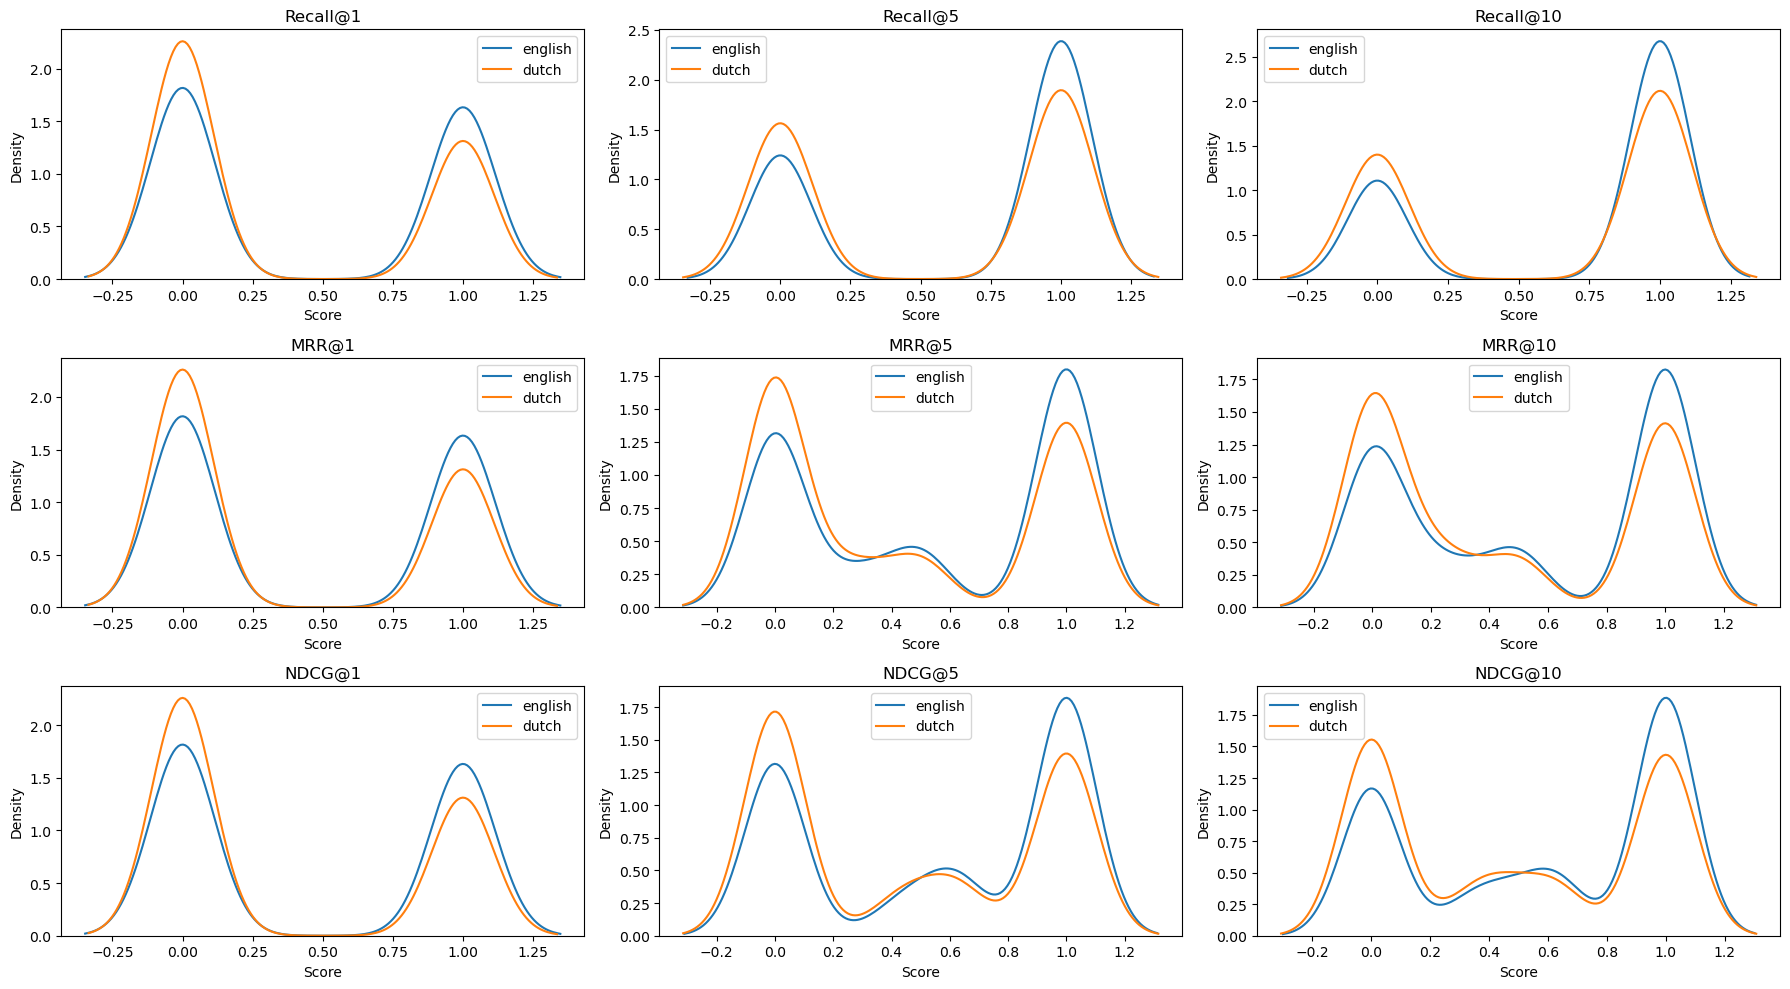

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# nine subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
axes = axes.flatten()

# Plot KDE plot
sns.kdeplot(df1, x="english", label='english', ax=axes[0])
sns.kdeplot(df1, x="dutch", label='dutch', ax=axes[0])
axes[0].set_title('Recall@1')
axes[0].legend()
axes[0].set_xlabel('Score')

sns.kdeplot(df2, x="english", label='english', ax=axes[1])
sns.kdeplot(df2, x="dutch", label='dutch', ax=axes[1])
axes[1].set_title('Recall@5')
axes[1].legend()
axes[1].set_xlabel('Score')

sns.kdeplot(df3, x="english",label='english', ax=axes[2])
sns.kdeplot(df3, x="dutch", label='dutch', ax=axes[2])
axes[2].set_title('Recall@10')
axes[2].legend()
axes[2].set_xlabel('Score')

sns.kdeplot(df4, x="english",label='english', ax=axes[3])
sns.kdeplot(df4, x="dutch", label='dutch', ax=axes[3])
axes[3].set_title('MRR@1')
axes[3].legend()
axes[3].set_xlabel('Score')

sns.kdeplot(df5, x="english",label='english', ax=axes[4])
sns.kdeplot(df5, x="dutch", label='dutch', ax=axes[4])
axes[4].set_title('MRR@5')
axes[4].legend()
axes[4].set_xlabel('Score')

sns.kdeplot(df6, x="english",label='english', ax=axes[5])
sns.kdeplot(df6, x="dutch", label='dutch', ax=axes[5])
axes[5].set_title('MRR@10')
axes[5].legend()
axes[5].set_xlabel('Score')

sns.kdeplot(df7, x="english",label='english', ax=axes[6])
sns.kdeplot(df7, x="dutch", label='dutch', ax=axes[6])
axes[6].set_title('NDCG@1')
axes[6].legend()
axes[6].set_xlabel('Score')

sns.kdeplot(df8, x="english",label='english', ax=axes[7])
sns.kdeplot(df8, x="dutch", label='dutch', ax=axes[7])
axes[7].set_title('NDCG@5')
axes[7].legend()
axes[7].set_xlabel('Score')

sns.kdeplot(df9, x="english",label='english', ax=axes[8])
sns.kdeplot(df9, x="dutch", label='dutch', ax=axes[8])
axes[8].set_title('NDCG@10')
axes[8].legend()
axes[8].set_xlabel('Score')


plt.tight_layout()
plt.savefig("bm25_performance_plots.pdf", bbox_inches="tight")  # Save as PDF for later use in Latex
plt.show()

In [25]:
import scipy as sp

# which statistical test we'll use depends on the distributions
# no normal distributions at first sight, let's verify this with Shapiro wilk:

print(f"Shapiro-Wilk on english recall: {sp.stats.shapiro(df1['english'])}")
print(f"Shapiro-Wilk on dutch recall: {sp.stats.shapiro(df1['dutch'])}")

print(f"Shapiro-Wilk on english recall: {sp.stats.shapiro(df2['english'])}")
print(f"Shapiro-Wilk on dutch recall: {sp.stats.shapiro(df2['dutch'])}")

print(f"Shapiro-Wilk on english recall: {sp.stats.shapiro(df3['english'])}")
print(f"Shapiro-Wilk on dutch recall: {sp.stats.shapiro(df3['dutch'])}")

print(f"Shapiro-Wilk on english mrr: {sp.stats.shapiro(df4['english'])}")
print(f"Shapiro-Wilk on dutch mrr: {sp.stats.shapiro(df4['dutch'])}")

print(f"Shapiro-Wilk on english mrr: {sp.stats.shapiro(df5['english'])}")
print(f"Shapiro-Wilk on dutch mrr: {sp.stats.shapiro(df5['dutch'])}")

print(f"Shapiro-Wilk on english mrr: {sp.stats.shapiro(df6['english'])}")
print(f"Shapiro-Wilk on dutch mrr: {sp.stats.shapiro(df6['dutch'])}")

print(f"Shapiro-Wilk on english ndcg: {sp.stats.shapiro(df7['english'])}")
print(f"Shapiro-Wilk on dutch ndcg: {sp.stats.shapiro(df7['dutch'])}")

print(f"Shapiro-Wilk on english ndcg: {sp.stats.shapiro(df8['english'])}")
print(f"Shapiro-Wilk on dutch ndcg: {sp.stats.shapiro(df8['dutch'])}")

print(f"Shapiro-Wilk on english ndcg: {sp.stats.shapiro(df9['english'])}")
print(f"Shapiro-Wilk on dutch ndcg: {sp.stats.shapiro(df9['dutch'])}")

# very low p-values, so we can indeed reject the null hypothesis that the data is normally distributed

Shapiro-Wilk on english recall: ShapiroResult(statistic=0.6355717816065538, pvalue=1.1590033146860406e-48)
Shapiro-Wilk on dutch recall: ShapiroResult(statistic=0.6104936558671128, pvalue=9.777773926013644e-50)
Shapiro-Wilk on english recall: ShapiroResult(statistic=0.5992446382460306, pvalue=3.366158138807605e-50)
Shapiro-Wilk on dutch recall: ShapiroResult(statistic=0.6332477509646867, pvalue=9.162926358775362e-49)
Shapiro-Wilk on english recall: ShapiroResult(statistic=0.5708324537235016, pvalue=2.5344954075151394e-51)
Shapiro-Wilk on dutch recall: ShapiroResult(statistic=0.6212989768545039, pvalue=2.7904172727187025e-49)
Shapiro-Wilk on english mrr: ShapiroResult(statistic=0.6355717816065538, pvalue=1.1590033146860406e-48)
Shapiro-Wilk on dutch mrr: ShapiroResult(statistic=0.6104936558671128, pvalue=9.777773926013644e-50)
Shapiro-Wilk on english mrr: ShapiroResult(statistic=0.7328210947278246, pvalue=8.178134873879496e-44)
Shapiro-Wilk on dutch mrr: ShapiroResult(statistic=0.726903

In [26]:
# considering the distribution of the data, I opt for the Wilcoxon-rank-sum test (also called MannWhithneyU), which is non-parametric and does not assume a normal distribution and is also insensitive to outliers.
# null-hypothesis: two distributions are the same
# alternative hypothesis: the base-group values (for english in this case) are significantly greater than the other values

print(sp.stats.mannwhitneyu(df1.english, df1.dutch, alternative="greater"))

print(sp.stats.mannwhitneyu(df2.english, df2.dutch, alternative="greater"))

print(sp.stats.mannwhitneyu(df3.english, df3.dutch, alternative="greater"))

print(sp.stats.mannwhitneyu(df4.english, df4.dutch, alternative="greater"))

print(sp.stats.mannwhitneyu(df5.english, df5.dutch, alternative="greater"))

print(sp.stats.mannwhitneyu(df6.english, df6.dutch, alternative="greater"))

print(sp.stats.mannwhitneyu(df7.english, df7.dutch, alternative="greater"))

print(sp.stats.mannwhitneyu(df8.english, df8.dutch, alternative="greater"))

print(sp.stats.mannwhitneyu(df9.english, df9.dutch, alternative="greater"))

# p-values higher than 0.05 mean that we have to accept the null-hypothesis: there is no difference between the performance of BM25 on English and Dutch

MannwhitneyuResult(statistic=1244250.0, pvalue=2.051521033819256e-09)
MannwhitneyuResult(statistic=1248750.0, pvalue=3.731380155759904e-10)
MannwhitneyuResult(statistic=1243500.0, pvalue=6.562194379354165e-10)
MannwhitneyuResult(statistic=1244250.0, pvalue=2.051521033819256e-09)
MannwhitneyuResult(statistic=1271883.5, pvalue=1.2903850170970229e-11)
MannwhitneyuResult(statistic=1275899.0, pvalue=6.5463256551280436e-12)
MannwhitneyuResult(statistic=1244250.0, pvalue=2.051521033819256e-09)
MannwhitneyuResult(statistic=1271883.5, pvalue=1.2903850170970229e-11)
MannwhitneyuResult(statistic=1275899.0, pvalue=6.5463256551280436e-12)
